In [12]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import spacy
import numpy as np

import random
import math
import time

### 1. 데이터셋 불러오기
 데이터셋은 PyTorch에서 제공하는 Multi30k dataset을 사용하겠습니다. 데이터 전처리는 spacy 에서 제공하는 토큰화 모듈을 사용합니다.
 
 우선, 전처리를 위해 필요한 함수를 지정합니다.

In [14]:
# 난수 생성
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [15]:
# 문장을 토큰화하는 모듈 설치
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 94.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 44.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [16]:
import de_core_news_sm
import en_core_web_sm

# 문장을 토큰화하는 모델을 불러옵니다.
spacy_en = en_core_web_sm.load()
spacy_de = de_core_news_sm.load()

# tokenizer function 생성
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]
    
# torchtext의 Field는 데이터를 어떻게 처리할지 조절합니다.
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [17]:
# 전처리 함수를 정의했으므로, 데이터셋을 불러오겠습니다.
# train, validation, test 데이터를 불러오고, 다운로드 합니다.
# Multi30k dataset을 사용하여, 30,000개의 영어, 독일, 프랑스어 문장을 포함합니다.
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC,TRG))

In [18]:
print(f'Number of training examples: {len(train_data.examples)}')
print(f'Number of validation examples: {len(valid_data.examples)}')
print(f'Number of testing examples: {len(test_data.examples)}')

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [19]:
# min_freq=2는 2번 이상 등장한 토큰을 출력합니다.
# 토큰이 1번만 등장했다면 <unk>로 대체합니다.
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [20]:
# 이제 Iterator을 생성합니다.
# Iterator 생성
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size=batch_size, device=device)

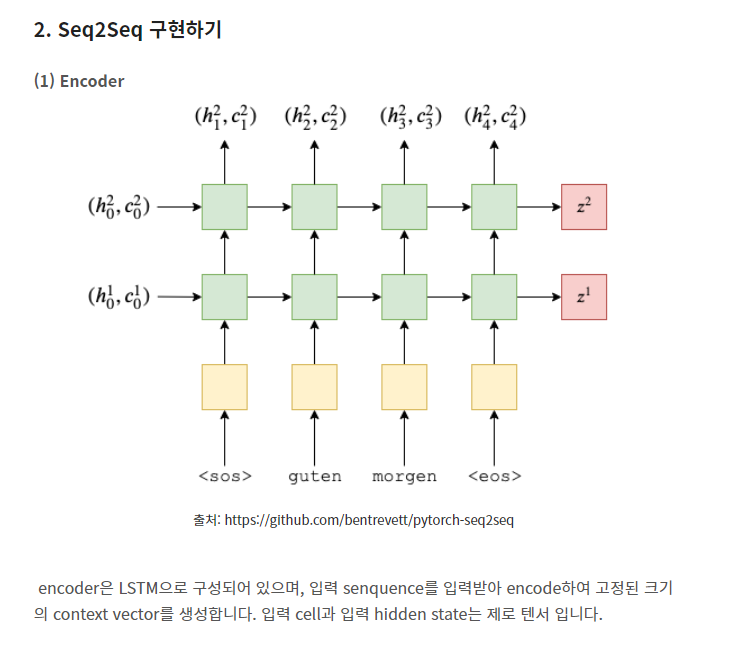

In [21]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        # embedding: 입력값을 emd_dim 벡터로 변경
        self.embedding = nn.Embedding(input_dim, emb_dim)

        # embedding을 입력받아 hid_dim 크기의 hidden state, cell 출력
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # sre: [src_len, batch_size]

        embedded = self.dropout(self.embedding(src))

        # initial hidden state는 zero tensor
        outputs, (hidden, cell) = self.rnn(embedded)

        # output: [src_len, batch_size, hid dim * n directions]
        # hidden: [n layers * n directions, batch_size, hid dim]
        # cell: [n layers * n directions, batch_size, hid dim]

        return hidden, cell

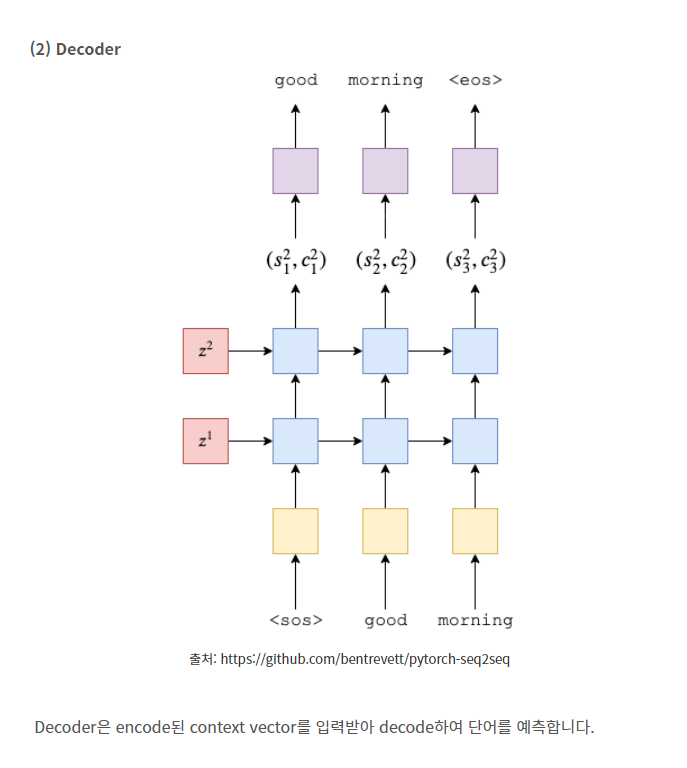

In [22]:
# decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        # content vector를 입력받아 emb_dim 출력
        self.embedding = nn.Embedding(output_dim, emb_dim)

        # embedding을 입력받아 hid_dim 크기의 hidden state, cell 출력
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input: [batch_size]
        # hidden: [n layers * n directions, batch_size, hid dim]
        # cell: [n layers * n directions, batch_size, hid dim]

        input = input.unsqueeze(0) # input: [1, batch_size], 첫번째 input은 <SOS>

        embedded = self.dropout(self.embedding(input)) # [1, batch_size, emd dim]

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output: [seq len, batch_size, hid dim * n directions]
        # hidden: [n layers * n directions, batch size, hid dim]
        # cell: [n layers * n directions, batch size, hid dim]

        prediction = self.fc_out(output.squeeze(0)) # [batch size, output dim]
        
        return prediction, hidden, cell

In [23]:
# Seq2Seq
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        # assert는 뒤의 조건이 True가 아니면 AssertError를 발생한다.
        # encoder와 decoder의 hid_dim이 일치하지 않는 경우 에러메세지
        assert encoder.hid_dim == decoder.hid_dim, \
            'Hidden dimensions of encoder decoder must be equal'
        # encoder와 decoder의 n_layers가 일치하지 않는 경우 에러메세지
        assert encoder.n_layers == decoder.n_layers, \
            'Encoder and decoder must have equal number of layers'

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: [src len, batch size]
        # trg: [trg len, batch size]
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0] # 타겟 토큰 길이 얻기
        trg_vocab_size = self.decoder.output_dim # context vector의 차원

        # decoder의 output을 저장하기 위한 tensor
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # initial hidden state
        hidden, cell = self.encoder(src)

        # 첫 번째 입력값 <sos> 토큰
        input = trg[0,:]

        for t in range(1,trg_len): # <eos> 제외하고 trg_len-1 만큼 반복
            output, hidden, cell = self.decoder(input, hidden, cell)

            # prediction 저장
            outputs[t] = output

            # teacher forcing을 사용할지, 말지 결정
            teacher_force = random.random() < teacher_forcing_ratio

            # 가장 높은 확률을 갖은 값 얻기
            top1 = output.argmax(1)

            # teacher forcing의 경우에 다음 lstm에 target token 입력
            input = trg[t] if teacher_force else top1

        return outputs

위 코드에 teacher forcing이 구현되어있습니다. teacher forcing은 일정 확률로 다음 lstm cell에 prediction이 아닌, target token을 입력하는 것입니다.

### 3. 학습하기
하이퍼파라미터를 지정합니다.

In [25]:
# 하이퍼 파라미터 지정
input_dim = len(SRC.vocab)
output_dim = len(TRG.vocab)
enc_emb_dim = 256 # 임베딩 차원
dec_emb_dim = 256
hid_dim = 512 # hidden state 차원
n_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

In [26]:
# 모델 생성
enc = Encoder(input_dim, enc_emb_dim, hid_dim, n_layers, enc_dropout)
dec = Decoder(output_dim, dec_emb_dim, hid_dim, n_layers, dec_dropout)

model = Seq2Seq(enc, dec, device).to(device)

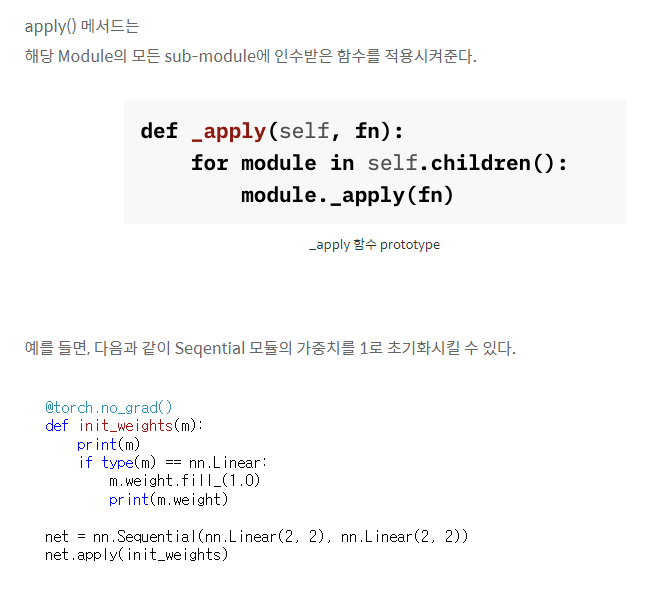

In [27]:
# 가중치 초기화
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [28]:
# 모델의 학습가능한 파라미터 수 측정
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainableparameters')

The model has 13,898,501 trainableparameters


In [29]:
# optimizer
optimizer = optim.Adam(model.parameters())

# loss function
# pad에 해당하는 index는 무시합니다.
trg_pad_idx = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index=trg_pad_idx)

In [31]:
# 학습을 위한 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()

        output = model(src,trg) # [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim) # loss 계산을 위해 1d로 변경
        trg = trg[1:].view(-1) # loss 계산을 위해 1d로 변경

        loss = criterion(output, trg)
        loss.backward()

        # 기울기 clip
        # https://sanghyu.tistory.com/87 ==> Gradient clipping (그래디언트 클리핑)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [32]:
# evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # output: [trg len, batch size, output dim]
            output = model(src, trg, 0) # teacher forcing off
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim) # [(trg len -1) * batch size, output dim]
            trg = trg[1:].view(-1) # [(trg len -1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [33]:
# 시간을 check하는 함수를 정의합니다.
# function to count training time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [34]:
# 학습 시작
num_epochs = 10
clip = 1

best_valid_loss = float('inf')

for epoch in range(num_epochs):
   
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, clip)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    # 언어 모델의 성능을 평가하는 척도인 퍼블렉서티perplexity(PPL)를 측정하는 방법 => https://kh-kim.gitbook.io/natural-language-processing-with-pytorch/00-cover-8/03-perpexity
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 34s
	Train Loss: 5.047 | Train PPL: 155.532
	 Val. Loss: 4.935 |  Val. PPL: 139.050
Epoch: 02 | Time: 0m 33s
	Train Loss: 4.478 | Train PPL:  88.055
	 Val. Loss: 4.758 |  Val. PPL: 116.488
Epoch: 03 | Time: 0m 33s
	Train Loss: 4.201 | Train PPL:  66.750
	 Val. Loss: 4.639 |  Val. PPL: 103.407
Epoch: 04 | Time: 0m 33s
	Train Loss: 4.014 | Train PPL:  55.350
	 Val. Loss: 4.592 |  Val. PPL:  98.728
Epoch: 05 | Time: 0m 33s
	Train Loss: 3.854 | Train PPL:  47.191
	 Val. Loss: 4.466 |  Val. PPL:  86.988
Epoch: 06 | Time: 0m 33s
	Train Loss: 3.726 | Train PPL:  41.495
	 Val. Loss: 4.383 |  Val. PPL:  80.093
Epoch: 07 | Time: 0m 33s
	Train Loss: 3.611 | Train PPL:  37.020
	 Val. Loss: 4.319 |  Val. PPL:  75.126
Epoch: 08 | Time: 0m 33s
	Train Loss: 3.479 | Train PPL:  32.422
	 Val. Loss: 4.179 |  Val. PPL:  65.268
Epoch: 09 | Time: 0m 33s
	Train Loss: 3.344 | Train PPL:  28.343
	 Val. Loss: 4.048 |  Val. PPL:  57.264
Epoch: 10 | Time: 0m 33s
	Train Loss: 3.247 | Train PPL

In [35]:
# best val loss일 때의 가중치를 불러옵니다.
model.load_state_dict(torch.load('tut1-model.pt'))

# test loss를 측정합니다.
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.013 | Test PPL:  55.316 |
